In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.setup_FOM import SimulationSetupFOM
from operators.poisson_solver import gmres_solver, fft_solver
from operators.FOM import psi_ln_aw, charge_density, total_mass, total_momentum, total_energy_k

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Linear Landau damping 

In [4]:
k_ = 0.5
setup = SimulationSetupFOM(Nx=200,
                           Nv=100,
                           epsilon=1e-2,
                           alpha_e=np.sqrt(2),
                           alpha_i=np.sqrt(2 / 1836),
                           u_e=0,
                           u_i=0,
                           L=20 * np.pi,
                           dt=1e-2,
                           T0=0,
                           T=20,
                           nu=20)

In [5]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

# simulation results

In [7]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_FOM_u_" + str(setup.Nv) + "_k_" + str(k_) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_FOM_t_" + str(setup.Nv) + "_k_" + str(k_) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(15000, 2001)
(2001,)


In [8]:
runtime = np.load("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_FOM_u_" + str(setup.Nv) + "_k_" + str(k_) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([1168.882287  ,  155.62834096])

In [9]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [10]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t), 1):
    print("time = ", sol_midpoint_t[ii])
    for n in range(setup.Nv):
        # unwind the flattening to solve the Vlasov-Poisson system
        # electrons
        state_e_midpoint[n, :-1, ii]  = sol_midpoint_u[n*setup.Nx: (n+1)*setup.Nx, ii]
        state_e_midpoint[n, -1, ii] = state_e_midpoint[n, 0, ii]

    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i,
                                        q_e=setup.q_e, q_i=setup.q_i,
                                        C0_e=state_e_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

time =  0.0


ValueError: could not broadcast input array from shape (0,) into shape (200,)

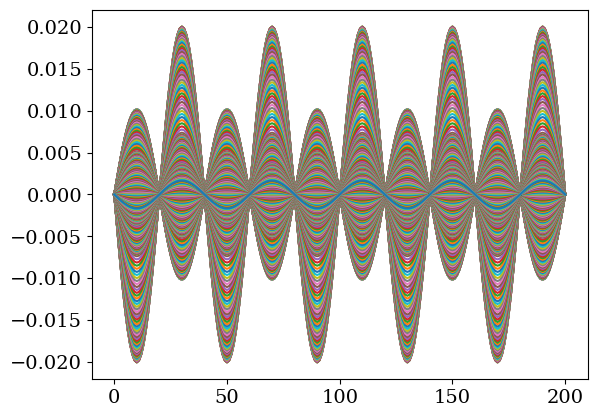

In [18]:
_  = plt.plot(E_midpoint[:, ::2])

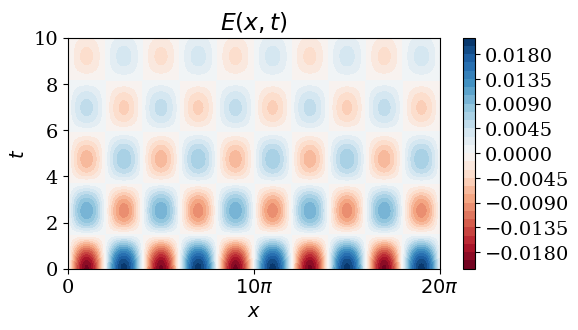

In [19]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi, 20*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
_ = ax.set_ylabel("$t$")

In [20]:
# compute the electric field k=1 mode amplitude using fft
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

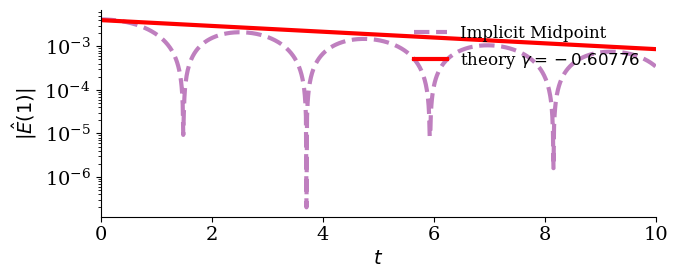

In [38]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 
ax.plot(sol_midpoint_t, 4e-3*np.exp(-0.153359*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.60776$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../figs/FOM/linear_landau/electric_field_damping_rate_" + str(setup.Nv) + ".png", dpi=600)

In [22]:
# save the electric field
np.save("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_midpoint_E_" + str(setup.Nv) + "_k_" + str(k_) + ".npy", E_midpoint)
np.save("../data/FOM/linear_landau/sample_" + str(k_) + "/sol_midpoint_E1_" + str(setup.Nv) + "_k_" + str(k_) + ".npy", E1_midpoint)

# conservation laws: mass, momentum, and energy

### mass conservation

In [23]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

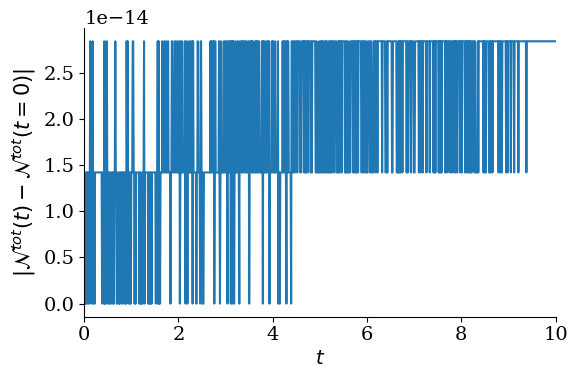

In [24]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [25]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=setup.alpha_e, dx=setup.dx,
                                           m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

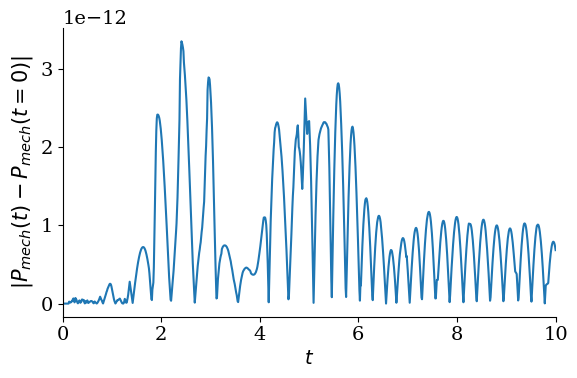

In [26]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [27]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

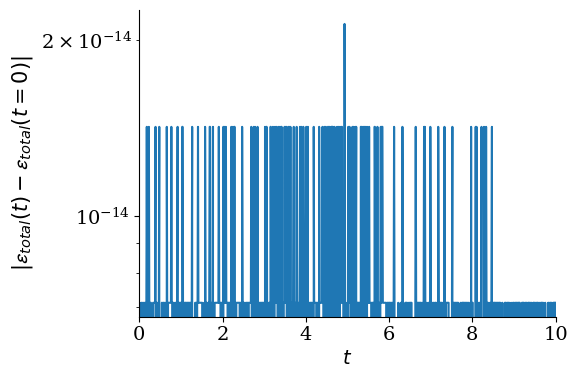

In [28]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

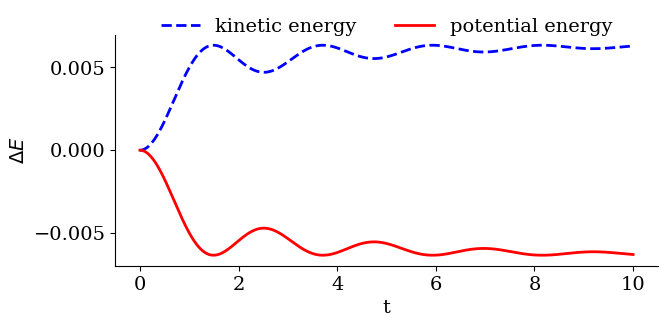

In [29]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
#ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

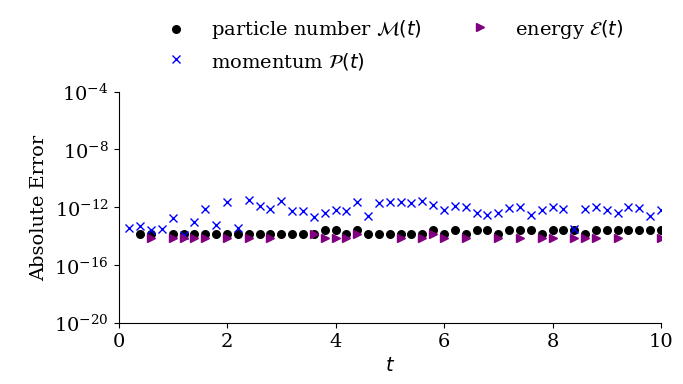

In [30]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_ylim(10**-20, 10**-4)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
#plt.savefig("../figs/FOM/linear_landau/conservation_" + str(setup.Nv) + "_two_stream_FOM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)

## Parameteric study 

In [31]:
k_vector = [0.2, 0.3, 0.4, 0.5, 0.6]

In [32]:
colors = plt.cm.viridis(np.linspace(0,1,len(k_vector)))

In [10]:
E_vector_coeff = np.zeros((len(k_vector), len(setup.t_vec)), dtype="complex128")

for kk in range(0, len(k_vector)):
    # update the standard deviation parameter 
    k_curr = k_vector[kk]
    E_vector_coeff[kk, :] = np.load("../data/FOM/linear_landau/sample_" + str(k_curr) + "/sol_midpoint_E1_" + str(setup.Nv) + "_k_" + str(k_curr) + ".npy")

ValueError: could not broadcast input array from shape (2001,) into shape (1001,)

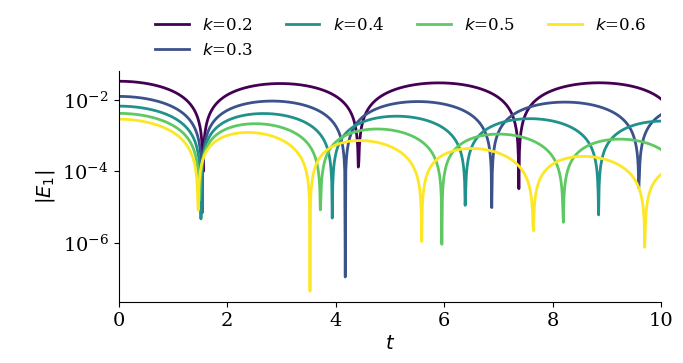

In [121]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
for kk in range(0, len(k_vector)):
    ax.plot(setup.t_vec, np.abs(E_vector_coeff[kk, :]), "-", linewidth=2, color=colors[kk], label=r"$k$=" + str(round(k_vector[kk], 1)))

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|E_{1}|$")
ax.set_xlabel("$ t$")
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_xlim(0, 10)
legend = ax.legend(ncols=4, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(1, 1.3))
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
#plt.savefig("../figs/FOM/linear_landau/linear_landau_electric_field_damping_rate_FOM_parameteric.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)

TypeError: psi_ln_aw() got an unexpected keyword argument 'xi'

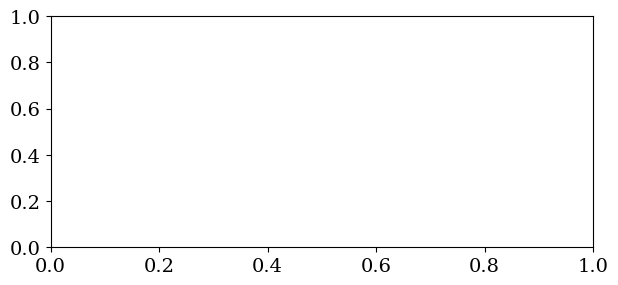

In [42]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
for kk in range(0, len(alpha_vector)):
    alpha_e = alpha_vector[kk]
    distribution = np.outer((1 + setup.epsilon*np.cos(x))/alpha_e, psi_ln_aw(xi=(v - setup.u_e)/alpha_e, v=v, alpha_s=alpha_e, u_s=setup.u_e, n=0))
    ax.plot(v, distribution[setup.Nx, :], "-", linewidth=2, color=colors[kk], label=r"$\alpha^{e}$=" + str(round(alpha_vector[kk], 1)))
    
legend = ax.legend(ncols=4, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(1, 1.3))
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$f^{e}(x, v, t=0)$")
ax.set_xlabel("$v$")
ax.set_xlim(-4, 4)
plt.savefig("../figs/FOM/linear_landau/linear_landau_initial_condition_cross_section.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)

# POD basis 

In [43]:
M=5

In [56]:
# load the simulation results
sol_u_FOM  = np.load("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[M*setup.Nx_total: setup.Nx_total*setup.Nv, :]

In [57]:
for kk in range(1, len(alpha_vector)):
    # update the standard deviation parameter 
    alpha_e = alpha_vector[kk]
    new_data =  np.load("../data/FOM/linear_landau/sample_" + str(alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(alpha_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[M*setup.Nx_total: setup.Nx_total* setup.Nv, :2001]
    sol_u_FOM = np.append(sol_u_FOM, new_data, axis=1)

In [58]:
np.shape(sol_u_FOM)

(3895, 11011)

In [59]:
# compute the SVD
U, S, _ = np.linalg.svd(sol_u_FOM, full_matrices=False)

In [60]:
# save the basis
np.save("../data/ROM/linear_landau/basis_" + str(M) + ".npy", U)
np.save("../data/ROM/linear_landau/singular_values_" + str(M) + ".npy", S)

In [61]:
S_3 = np.load("../data/ROM/linear_landau/singular_values_3.npy")
S_4 = np.load("../data/ROM/linear_landau/singular_values_4.npy")
S_5 = np.load("../data/ROM/linear_landau/singular_values_5.npy")

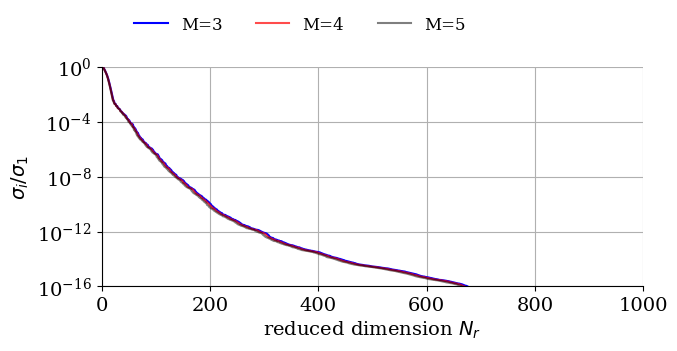

In [75]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(np.arange(len(S_3)), (np.abs(S_3)/np.max(S_3[0])), color="blue", alpha=1, label="M=3")
ax.plot(np.arange(len(S_4)), (np.abs(S_4)/np.max(S_4[0])), color="red", alpha=0.7, label="M=4")
ax.plot(np.arange(len(S_5)), (np.abs(S_5)/np.max(S_5[0])), color="BLACK", alpha=0.5, label="M=5")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\sigma_{i}/\sigma_{1}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_yscale("log")
ax.set_ylim(10**-16, 1)
ax.set_xlim(0, 1000)
plt.grid()

legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=12, loc='upper right', bbox_to_anchor=(0.7, 1.3))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/linear_landau/singular_value_decay_linear_landau.png", dpi=600)

In [ ]:
# plot reduced basis 